In [1]:
!pip -q install jcopdl efficientnet_pytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from time import sleep

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

import jcopdl
from jcopdl.callback import Callback, set_config

from efficientnet_pytorch import EfficientNet


In [3]:
TRAIN_IMAGES_PATH = "/kaggle/input/siim-isic-train-resized/"
TEST_IMAGES_PATH = "/kaggle/input/siim-isic-test-resized/"
TEST_DF_PATH = "/kaggle/input/siim-isic-melanoma-classification/test.csv"
TRAIN_DF_PATH = "/kaggle/input/siim-isic-melanoma-classification/train.csv"

config = set_config(dict(image_size=(256, 256), hidden_layer=600, dropout=0.4, batch_size=32, lr=1e-4))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data preprocessing and loading


In [4]:
class MelanomaDataset(Dataset):
    
    def __init__(self, df, SS, OHE, transform=None, test=False):
        
    
        self.df = df
        self._ages = SS.transform(self.df[["age_approx"]])
        self._oh_categories = OHE.transform(self.df[["sex", "anatom_site_general_challenge"]])
        self.transform = transform
        self._test = test
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = Image.open(self.df["image_name"].iloc[idx])
        age = self._ages[idx]
        oh_categories = self._oh_categories[idx]
        meta = np.r_[age, oh_categories].astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
        
        if not self._test: 
            target = self.df["target"].iloc[idx]
            return (image, meta), target
        else:
            return image, meta
        
    
    def __len__(self):
        
        return self.df.shape[0]
        
        

In [5]:
class MelanomaDatasetBuilder():
    
    def __init__(self, train_csv, test_csv):
        
        self.df_train = pd.read_csv(train_csv)
        self.df_test = pd.read_csv(test_csv)
        
        self.df_train = self._preprocess(self.df_train)
        self.df_test = self._preprocess(self.df_test, test=True)
        
        # Splitting the validation and training 
        self.df_train, self.df_val = train_test_split(self.df_train, stratify=self.df_train["target"], test_size=0.1)
        
        self.SS, self.OHE = StandardScaler(), OneHotEncoder(sparse=False)
        self.SS.fit(self.df_train[["age_approx"]])
        self.OHE.fit(self.df_train[["sex", "anatom_site_general_challenge"]])
        
        
    
    def __call__(self, train_transform=None, test_transform=None):
        
        train_dataset = MelanomaDataset(self.df_train, self.SS, self.OHE, train_transform)
        val_dataset = MelanomaDataset(self.df_val, self.SS, self.OHE, test_transform)
        test_dataset = MelanomaDataset(self.df_test, self.SS, self.OHE, test_transform, test=True)

        return train_dataset, val_dataset, test_dataset
    
    def _preprocess(self, df, test=False):
        
        df = df.fillna({"sex": "male",
                                  "age_approx": self.df_train["age_approx"].mode().iloc[0],
                                  "anatom_site_general_challenge": "torso"})
        
        DIR = TEST_IMAGES_PATH if test else TRAIN_IMAGES_PATH
        
        df["image_name"] = df["image_name"].apply(lambda x : DIR + x + ".jpg")
        
        return df
        
        
    
        

In [6]:
dataset_builder = MelanomaDatasetBuilder(TRAIN_DF_PATH, TEST_DF_PATH)

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=config.image_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
     transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_dataset, val_dataset, test_dataset = dataset_builder(train_transforms, test_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader, test_dataloader = DataLoader(val_dataset, batch_size=1), DataLoader(test_dataset, batch_size=1)

In [7]:
class LinLeakBNDrop(nn.Module):
    
    def __init__(self, in_features, out_features, dropout):
        
        super().__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(in_features, out_features), 
            nn.LeakyReLU(), 
            nn.BatchNorm1d(out_features), 
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        
        return self.layer(x)

class LinELUBNDrop(nn.Module):
    
    def __init__(self, in_features, out_features, dropout):
        
        super().__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(in_features, out_features), 
            nn.ELU(), 
            nn.BatchNorm1d(out_features), 
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        
        return self.layer(x)
    

class MelanomaDense(nn.Module):
    
    def __init__(self, in_features, hidden_layer=400, dropout=0.3):
        
        super().__init__()
        
        self.layer = nn.Sequential(
            LinELUBNDrop(in_features, hidden_layer, dropout), 
            LinELUBNDrop(hidden_layer, hidden_layer, dropout),
            LinELUBNDrop(hidden_layer, hidden_layer, dropout)
        )
        
        self.out_features = hidden_layer
        
    def forward(self, x):
        
        return self.layer(x)
        

class MelanomaNet(nn.Module):
    
    def __init__(self, base_model):
        """
        Base Model is expected to be an efficient net. 
        """
        
        super().__init__()
        
        self.base_model = base_model
        self.base_model._fc = LinELUBNDrop(self.base_model._fc.in_features, config.hidden_layer, config.dropout)
#         self.base_model._fc = nn.Linear(self.base_model._fc.in_features, config.hidden_layer)
        
        self.dense = MelanomaDense(9, config.hidden_layer, config.dropout)
        
        self.output = nn.Linear(config.hidden_layer + config.hidden_layer, 1)
        
        
        
    def forward(self, x):
        
        image, meta = x
        outCNN = self.base_model(image)
        outDNN = self.dense(meta)
        
        features = torch.cat((outCNN, outDNN), dim=1)
        return self.output(features)
    
    def freeze(self):
        
        for name, child in self.base_model.named_children():
            if name != "_fc":
                for param in child.parameters():
                    param.requires_grad = False
        
    
    def unfreeze(self):
        
        for param in self.base_model.parameters():
            param.requires_grad = True
        
        

In [8]:
base_model = EfficientNet.from_pretrained("efficientnet-b4")
model = MelanomaNet(base_model)
model = model.to(device)
model.freeze()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer= torch.optim.AdamW(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.2, patience=2)
callback = Callback(model, config, early_stop_patience=4, outdir="model")

In [10]:
class ModelTrainer():
    
    def __init__(self, model, criterion, optimizer, scheduler,  device, callback, tqdm=True):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.callback = callback 
        self.device = device
        self.tqdm = tqdm
        
        self.epoch = 1
        
        
    def train_loop(self, train_dataloader):
        
        cost = 0
        self.model.train()
        
        train_pred = torch.zeros(len(train_dataloader.dataset), 1, dtype=torch.float32, device = self.device, requires_grad=False)
        train_true = torch.zeros(len(train_dataloader.dataset), 1, dtype=torch.float32, device = self.device, requires_grad=False)
        
        t = tqdm(train_dataloader, desc=f"Epoch {self.epoch}") if self.tqdm == True else train_dataloader
        
        for i, (features, target) in enumerate(t):
            
            features[0] = features[0].to(device)
            features[1] = features[1].to(device)
            target = target.to(device).float()
            
            pred = self.model(features)
            loss = self.criterion(pred, target.unsqueeze(1))
            loss.backward()
            
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            cost += loss.item() * features[1].shape[0]
            
            train_true[i*train_dataloader.batch_size:min((i+1)*train_dataloader.batch_size, len(train_dataloader.dataset))]=\
            target.unsqueeze(1)
            
            train_pred[i*train_dataloader.batch_size:min((i+1)*train_dataloader.batch_size, len(train_dataloader.dataset))]=\
            pred
            
        roc = roc_auc_score(train_true.cpu().detach().numpy(), train_pred.cpu().detach
                            ().numpy())
        
        return cost / len(train_dataloader.dataset), roc
    
    
    def validate_loop(self, val_dataloader):
        
        cost = 0
        roc = 0
        self.model.eval()
        
        val_preds = torch.zeros(len(val_dataloader.dataset), 1, dtype=torch.float32, device=self.device)
        val_true = torch.zeros(len(val_dataloader.dataset), 1, dtype=torch.float32, device=self.device)
        
        t = tqdm(val_dataloader, desc=f"Epoch {self.epoch}") if self.tqdm == True else val_dataloader
        
        with torch.no_grad():
            for i, (features, target) in enumerate(t):
                features[0] = features[0].to(device)
                features[1] = features[1].to(device)
                target = target.to(device).float()
            
                pred = self.model(features)
                loss = self.criterion(pred, target.unsqueeze(1)) 
                cost += loss.item() * features[1].shape[0]
                val_preds[i] = pred
                val_true[i] = target
                
        
        roc = roc_auc_score(val_true.cpu().numpy(), val_preds.cpu().numpy())
        
        return (cost / len(val_dataloader.dataset)), roc
    
    def train(self, train_dataloader, val_dataloader, max_epochs=np.inf):
        
        while self.epoch < max_epochs:
            train_cost, train_score = self.train_loop(train_dataloader)
            val_cost, val_score = self.validate_loop(val_dataloader)
            
            self.scheduler.step(val_score)
            self.epoch += 1
            
            _ = self.callback.log(train_cost, val_cost, train_score, val_score)
            _ = self.callback.save_checkpoint()
        
            if self.callback.early_stopping(self.model, monitor="test_score"):
                self.callback.plot_cost()
                self.callback.plot_score()
                break

Epoch 2:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4208 | Test_cost  = 0.1601 | Train_score = 0.5798 | Test_score = 0.6111 |


Epoch 3:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1298 | Test_cost  = 0.0864 | Train_score = 0.5930 | Test_score = 0.7755 |


Epoch 4:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0988 | Test_cost  = 0.0805 | Train_score = 0.6596 | Test_score = 0.7608 |
==> EarlyStop patience =  1 | Best test_score: 0.7755


Epoch 5:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0945 | Test_cost  = 0.0762 | Train_score = 0.6851 | Test_score = 0.8176 |


Epoch 6:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0914 | Test_cost  = 0.0724 | Train_score = 0.7138 | Test_score = 0.8384 |


Epoch 7:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0886 | Test_cost  = 0.0700 | Train_score = 0.7281 | Test_score = 0.8676 |


Epoch 8:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0863 | Test_cost  = 0.0712 | Train_score = 0.7432 | Test_score = 0.8464 |
==> EarlyStop patience =  1 | Best test_score: 0.8676


Epoch 9:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0859 | Test_cost  = 0.0703 | Train_score = 0.7347 | Test_score = 0.8537 |
==> EarlyStop patience =  2 | Best test_score: 0.8676


Epoch 10:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0831 | Test_cost  = 0.0708 | Train_score = 0.7584 | Test_score = 0.8520 |
==> EarlyStop patience =  3 | Best test_score: 0.8676


Epoch 10: 100%|██████████| 3313/3313 [01:42<00:00, 32.46it/s]



Epoch    10
Train_cost  = 0.0814 | Test_cost  = 0.0714 | Train_score = 0.7695 | Test_score = 0.8648 |
==> EarlyStop patience =  4 | Best test_score: 0.8676
==> Execute Early Stopping at epoch: 10 | Best test_score: 0.8676
==> Best model is saved at model


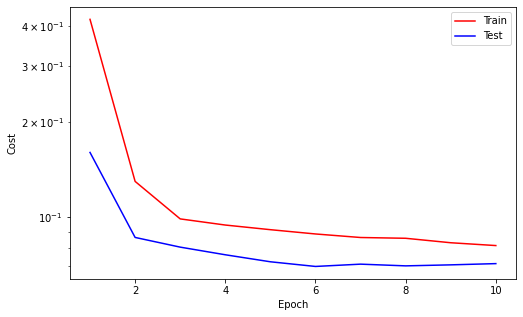

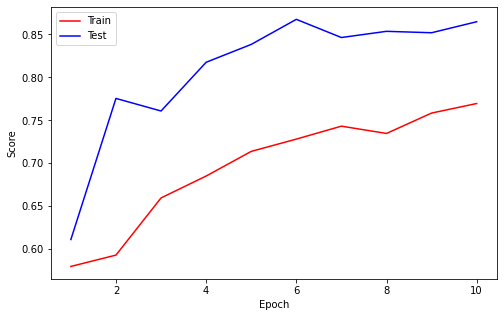

In [11]:
modeltrainer = ModelTrainer(model, criterion, optimizer, scheduler, device, callback, tqdm=True)
modeltrainer.train(train_dataloader, val_dataloader)

Epoch 12:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0845 | Test_cost  = 0.0672 | Train_score = 0.7600 | Test_score = 0.8947 |


Epoch 13:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0787 | Test_cost  = 0.0658 | Train_score = 0.8055 | Test_score = 0.8919 |
==> EarlyStop patience =  1 | Best test_score: 0.8947


Epoch 14:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0775 | Test_cost  = 0.0647 | Train_score = 0.8139 | Test_score = 0.8972 |


Epoch 15:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0746 | Test_cost  = 0.0644 | Train_score = 0.8379 | Test_score = 0.8998 |


Epoch 16:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0727 | Test_cost  = 0.0643 | Train_score = 0.8479 | Test_score = 0.8979 |
==> EarlyStop patience =  1 | Best test_score: 0.8998


Epoch 17:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0699 | Test_cost  = 0.0646 | Train_score = 0.8684 | Test_score = 0.8964 |
==> EarlyStop patience =  2 | Best test_score: 0.8998


Epoch 18:   0%|          | 0/932 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0683 | Test_cost  = 0.0640 | Train_score = 0.8783 | Test_score = 0.8944 |
==> EarlyStop patience =  3 | Best test_score: 0.8998


Epoch 18: 100%|██████████| 3313/3313 [01:46<00:00, 31.15it/s]



Epoch    18
Train_cost  = 0.0660 | Test_cost  = 0.0642 | Train_score = 0.8821 | Test_score = 0.8948 |
==> EarlyStop patience =  4 | Best test_score: 0.8998
==> Execute Early Stopping at epoch: 18 | Best test_score: 0.8998
==> Best model is saved at model


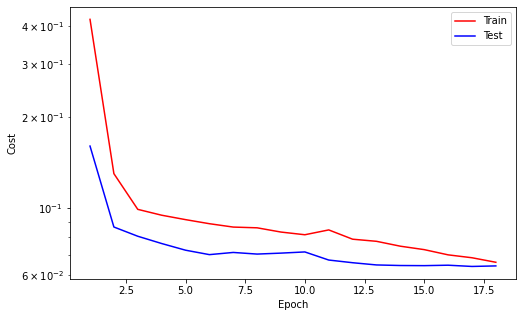

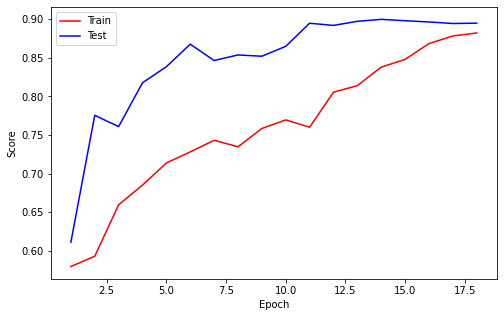

In [12]:
model.unfreeze()
modeltrainer.optimizer= torch.optim.AdamW(model.parameters(), lr=1e-5)
modeltrainer.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(modeltrainer.optimizer,
                                                                    mode="max", factor=0.2, 
                                                                    patience=2)

modeltrainer.train(train_dataloader, val_dataloader)

In [13]:
model.eval()
preds = np.zeros(len(test_dataloader.dataset))
with torch.no_grad():
    for i, features in enumerate(test_dataloader):
        features[0], features[1] = features[0].to(device), features[1].to(device)
        pred = torch.sigmoid(model(features))
        preds[i] = pred.cpu().item()

In [14]:
df_sub = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
df_sub["target"] = preds
df_sub.to_csv("submission.csv", index=False)